In [77]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image

from common.constant import TRAIN_CSV_PATH, TRAIN_IMG_ROOT
from common.rle import rle_decode
from common.model_util import compute_ap_range as compute_ap_range2

In [78]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# 垂直方向への反転
class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

# 水平方向への反転
class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

# 正規化
class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # オーグメンテーション
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [79]:
WIDTH = 500
HEIGHT = 300
NORMALIZE = False
BOX_DETECTIONS_PER_IMG = 500


class SemiDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df

        # リサイズ
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('image')['rle'].agg(lambda x: list(x)).reset_index()
        temp_df = temp_df.merge(self.df[["image","height", "width"]].drop_duplicates(), on="image", how="inner").reset_index(drop=True)
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['image'],
                    'path': self.image_dir / row['image'],
                    'annotations': row["rle"],
                    'height': row["height"],
                    'width': row["width"]
                    }
    
    def get_box(self, a_mask):
        ''' 与えられたマスクのバウンディングボックスを取得 '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' 画像とターゲットを取得する '''
        # 画像の読み込み
        img_path = self.image_info[idx]["path"]
        img = Image.open(img_path).convert("RGB")

        # 読み込んだ画像をリサイズ
        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        # アノテーションや高さ・幅の情報を取得
        info = self.image_info[idx]

        # アノテーションの数
        n_objects = len(info['annotations'])
        # mask作る
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []

        for i, annotation in enumerate(info['annotations']):
            # rleをmaskに変更
            a_mask = rle_decode(annotation, (info['height'], info['width']))
            a_mask = Image.fromarray(a_mask)
            
            # maskもリサイズ
            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            
            boxes.append(self.get_box(a_mask))

        # ラベルは1種類
        labels = [1 for _ in range(n_objects)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # 今回使用するMask R-CNNで求められるデータをまとめる
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)



def get_model():
    # クラス数：半導体（検出したいもの）+背景
    NUM_CLASSES = 2
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, 
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN, 
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                  box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # 分類用のinput feature数
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # headの付け替え
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    # 物体検出用のinput feature数
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # headの付け替え
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    return model

In [48]:
df = pd.read_csv(TRAIN_CSV_PATH)
ds = SemiDataset(TRAIN_IMG_ROOT, df, transforms=get_transform(False), resize=True)
img, target = ds[10]
target = {k: v.cpu().numpy() for k, v in target.items()}
dummy_preds = {k: v[:len(v)-1] for k, v in target.items()}
dummy_preds['scores'] = np.array([0.9] * dummy_preds['boxes'].shape[0])

In [49]:
print(target['masks'].shape, target['boxes'].shape, target['labels'].shape)
print(dummy_preds['masks'].shape, dummy_preds['boxes'].shape, dummy_preds['labels'].shape)

(161, 300, 500) (161, 4) (161,)
(160, 300, 500) (160, 4) (160,)


In [50]:
def trim_zeros(x: np.ndarray):
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]


def compute_overlaps_masks(masks1: np.ndarray, masks2: np.ndarray):
    """masks1とmasks2のiou行列を作成する
    Args:
        masks1: (masks1のインスタンス数, Height, Width)
        masks2: (masks2のインスタンス数, Height, Width)
    Returns:
        masks1とmasks2のインスタンス間のIOU行列
        (masks1のインスタンス数, masks2のインスタンス数)
    """
    masks1_instances = masks1.shape[0]
    masks2_instances = masks2.shape[0]
    if masks1_instances == 0 or masks2_instances == 0:
        return np.zeros((masks1_instances, masks2_instances))
    # flat化: (インスタンス数, Height, Width) => (インスタンス数, Height * Width)
    masks1 = np.reshape(masks1, (masks1_instances, -1)).astype(np.float32)
    masks2 = np.reshape(masks2, (masks2_instances, -1)).astype(np.float32)
    area1 = np.sum(masks1, axis=1)
    area2 = np.sum(masks2, axis=1)
    intersections = np.dot(masks1, masks2.T)
    union = area1[:, None] + area2[None, :] - intersections
    return intersections / union


def compute_matches(
    gt_boxes, gt_class_ids, gt_masks,
    pred_boxes, pred_class_ids, pred_scores, pred_masks,
    iou_th=0.5, score_th=0.0
):
    """正解マスクと対応する予測マスクのインデックスを返す
    Args:
        gt_boxes: 正解バウンディングボックス (インスタンス数, ())
    """
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[:gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # スコア降順にソート
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[indices]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)
    
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        sorted_idx = np.argsort(overlaps[i])[::-1]
        low_score_idx = np.where(overlaps[i, sorted_idx] < score_th)[0]
        if low_score_idx.size > 0:
            sorted_idx = sorted_idx[:low_score_idx[0]]
        for j in sorted_idx:
            if gt_match[j] > -1:
                continue
            iou = overlaps[i, j]
            # jはiに対して降順のインデックスのためiou < iout_thになった時点でその先は計算する必要がないのでbreak
            if iou < iou_th:
                break
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break
    return gt_match, pred_match, overlaps


def compute_ap(
    gt_boxes, gt_class_ids, gt_masks,
    pred_boxes, pred_class_ids, pred_scores, pred_masks,
    iou_th=0.5
):
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_th
    )
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
    
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])
    
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) * precisions[indices])
    return mAP, precisions, recalls, overlaps


def compute_ap_range(
    gt_boxes, gt_class_ids, gt_masks,
    pred_boxes, pred_class_ids, pred_scores, pred_masks,
    iou_thresholds=None, verbose=1
):
    iou_thresholds = iou_thresholds or np.arange(0.5, 1.0, 0.05)
    AP = []
    for iou_thoreshold in iou_thresholds:
        ap, _, _, _ = compute_ap(
            gt_boxes, gt_class_ids, gt_masks,
            pred_boxes, pred_class_ids, pred_scores, pred_masks,
            iou_th=iou_thoreshold
        )
        if verbose:
            print(f'AP @{iou_thoreshold:.3f}:\t {ap:.3f}')
        AP.append(ap)
    AP = np.mean(AP)
    if verbose:
        print(f'AP @{iou_thresholds[0]:.3f}-{iou_thresholds[-1]:.3f}:\t {AP:.3f}')
    return AP

In [51]:
ap = compute_ap_range(
    target['boxes'], target['labels'], target['masks'],
    dummy_preds['boxes'], dummy_preds['labels'], dummy_preds['scores'], dummy_preds['masks'],
)

AP @0.500:	 0.994
AP @0.550:	 0.994
AP @0.600:	 0.994
AP @0.650:	 0.994
AP @0.700:	 0.994
AP @0.750:	 0.994
AP @0.800:	 0.994
AP @0.850:	 0.994
AP @0.900:	 0.994
AP @0.950:	 0.994
AP @0.500-0.950:	 0.994


In [55]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_model()
model.to(DEVICE)


model.load_state_dict(torch.load('../../dst/pytorch_model-e5.bin'))
model.eval()

with torch.no_grad():
    preds = model([img.to(DEVICE)])[0]
    preds = {k: v.cpu().numpy() for k, v in preds.items()}

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
pred_boxes = preds['boxes']
pred_labels = preds['labels']
pred_scores = preds['scores']
pred_masks = preds['masks'][:, 0, ...]

use_masks_filter = pred_scores > 0
pred_boxes = pred_boxes[use_masks_filter]
pred_labels = pred_labels[use_masks_filter]
pred_scores = pred_scores[use_masks_filter]
pred_masks = pred_masks[use_masks_filter]
pred_masks = (pred_masks > 0.5).astype(int)

ap = compute_ap_range(
    target['boxes'], target['labels'], target['masks'],
    pred_boxes, pred_labels, pred_scores, pred_masks,
)

AP @0.500:	 0.557
AP @0.550:	 0.511
AP @0.600:	 0.500
AP @0.650:	 0.429
AP @0.700:	 0.396
AP @0.750:	 0.254
AP @0.800:	 0.232
AP @0.850:	 0.162
AP @0.900:	 0.044
AP @0.950:	 0.008
AP @0.500-0.950:	 0.309


In [82]:
pred_boxes = preds['boxes']
pred_labels = preds['labels']
pred_scores = preds['scores']
pred_masks = preds['masks'][:, 0, ...]

use_masks_filter = pred_scores > 0
pred_boxes = pred_boxes[use_masks_filter]
pred_labels = pred_labels[use_masks_filter]
pred_scores = pred_scores[use_masks_filter]
pred_masks = pred_masks[use_masks_filter]
pred_masks = (pred_masks > 0.5).astype(int)

ap = compute_ap_range2(
    target['boxes'], target['labels'], target['masks'],
    pred_boxes, pred_labels, pred_scores, pred_masks,
    verbose=1
)
ap

AP @0.500:	 0.557
AP @0.550:	 0.511
AP @0.600:	 0.500
AP @0.650:	 0.429
AP @0.700:	 0.396
AP @0.750:	 0.254
AP @0.800:	 0.232
AP @0.850:	 0.162
AP @0.900:	 0.044
AP @0.950:	 0.008
AP @0.500-0.950:	 0.309


0.30927146281187406

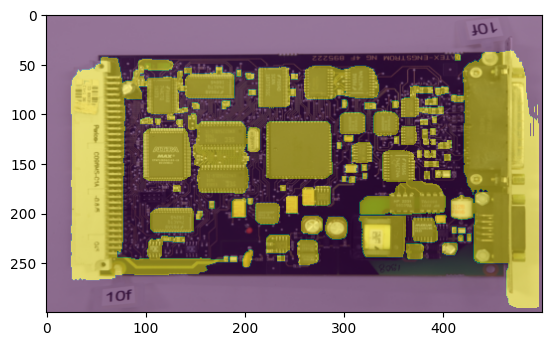

In [76]:
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.imshow((pred_masks.sum(axis=0) > 0).astype(int), alpha=0.5)